In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import random
from feret_utils import get_feret_files_and_tags_dict, run_face_detection, create_dataset, create_dataset_gs
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plot
from IPython.display import Image
import cv2 as cv
import tensorflow as tf
import scipy
from datetime import datetime
import pickle
tfe = tf.contrib.eager

In [2]:
# Set tf basic settings
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
tf.enable_eager_execution()

1.10.0


In [3]:
import pickle
# Unpickle data_dict holding the training and evaluation examples after performing data augmentation and regulerization
with open('feret_data_dict_gs.pickle', 'rb') as handle:
    subject_list, data_dict, mean_image, std_image = pickle.load(handle)

# Show dataset sizes and a few images examples

(6931, 96, 96, 1)
(6931,)
(268, 96, 96, 1)
(268,)
ID: 0


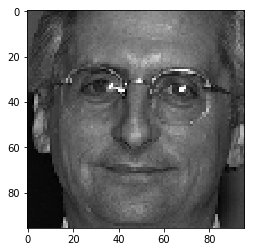

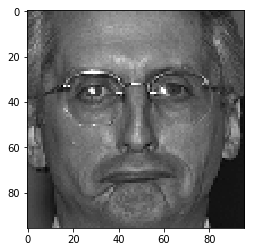

ID: 2


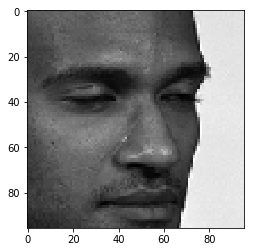

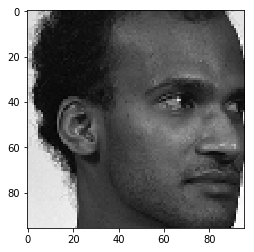

ID: 38


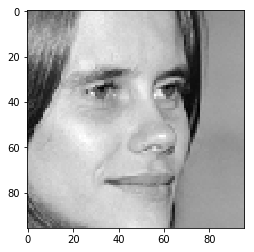

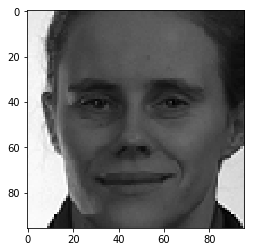

In [4]:
# Show the sizes of the datasets and a few examples of the images in it
print(data_dict['X_train'].shape)
print(data_dict['y_train'].shape)
print(data_dict['X_eval'].shape)
print(data_dict['y_eval'].shape)

for x in [1,43,501]:
    print("ID: {}".format(int(data_dict['y_train'][x])))
    for i in range(2):
        pic = data_dict['X_train'][x+i]
        pic = pic * std_image + mean_image
        pic = pic.reshape(96,96)
        imshow(pic, cmap='gray')
        plot.show()

# Model with a combined classifier running parallel

### The 2 phases of training are comprised of the following losses:
1. Classification loss: standard softmax loss choosing out of 700 classes
2. Image comparison loss: a loss measuring the L2 distance between the feature extraction layer of 2 images and socring according to the following:

    if image_A[id] == image_B[id]:
        loss =+ L2 distance between feature layers of image_A and image_B
    else (both faces are of different people):
        loss =+ min(0, similarity_threshold - L2 distance between feature layers of image_A and image_B)
        *similarity threshold is a parameter which can be changed

In [5]:
# Create a classifier model which uses the data dict to create a multi loss optimizer which tests:
# A. classification of input picture
# B. similarity of 2 images
class CombinedClassifier(tf.keras.Model):
    def __init__(self, num_of_ids, loss_type="COMBINED", similarity_threshold=1):
        super().__init__()
        self.loss_type = loss_type
        self.similarity_threshold = similarity_threshold
        self.num_of_ids = num_of_ids
        
        # Conv layer 1 + Pooling
        self.conv1a = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=[4, 4],
                                            strides=(1, 1),
                                            padding='valid',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool1a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 2 + Pooling
        self.conv2a = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool2a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 3 + Pooling
        self.conv3a = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool3a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Dense output layer
        self.fc1a = tf.keras.layers.Dense(16384, activation=tf.nn.relu)
        
        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        
        # Dense layer for classes
        self.fc2a = tf.keras.layers.Dense(num_of_ids)
        
        # Optimizers
        self.optimizer1 = tf.train.AdamOptimizer(learning_rate = 0.5*1e-4)
        self.optimizer2 = tf.train.AdamOptimizer(learning_rate = 1e-5)
        
    def call(self, inputs, training=True, **kwargs):
        half_batch_size = int(int(inputs.shape[0]) / 2)
        batch_size = int(half_batch_size * 2)
        
        # Input Layer
        input_layer = tf.reshape(inputs, [-1, 96, 96, 1])
        
        # Flow for first classifier
        x1 = self.conv1a(input_layer)
        x1 = self.pool1a(x1)
        x1 = self.conv2a(x1)
        x1 = self.pool2a(x1)
        x1 = self.conv3a(x1)
        x1 = self.pool3a(x1)
        x1 = tf.reshape(x1, [x1.shape[0], -1])
        x1_id_layer = self.fc1a(x1)
        
        # On training use dropout and get distances
        if (training):
            x1_dropout = self.dropout(x1_id_layer)
            x1_logits = self.fc2a(x1_dropout)
            distances = tf.reduce_mean((x1_id_layer[0:half_batch_size] - x1_id_layer[half_batch_size:batch_size])**2, axis=1)

        else:
            x1_logits = self.fc2a(x1_id_layer)
            distances = 0

        
        return x1_logits, x1_id_layer, distances 
    
    def loss(self, logits1, labels1, distances, batch_size):        
        half_batch_size = int(batch_size / 2)
        
        # To make sure that both halves are equal
        batch_size = int(half_batch_size * 2)
        
        # Calculate losses according to classification requirments and comparison requirement
        # Loss 1: classification requirement
        onehot_labels = tf.one_hot(indices=tf.cast(labels1, tf.int32), depth = num_of_ids)
        loss_1 = tf.losses.softmax_cross_entropy(onehot_labels, logits1)
        
        # Loss 2: comparison requirement
        same = np.where(np.array(labels1[0:half_batch_size] - labels1[half_batch_size:batch_size]) == 0)[0]
        diff = np.arange(half_batch_size)
        diff = np.delete(diff, same)
        if (len(same) > 0):
            same_loss = tf.reduce_mean(tf.gather(distances, same)) * (len(same)/batch_size)
        else:
            same_loss = 0
        diff_loss = (tf.reduce_mean(tf.maximum(0, self.similarity_threshold - tf.gather(distances, diff)))
                        * (len(diff)/batch_size))
        
        loss_2 = same_loss + diff_loss
        
        return loss_1, loss_2
    
    def optimize(self, inputs, labels):
        with tf.GradientTape(persistent=True) as tape:
            x1_logits, x1_id_layer, distances = self(inputs)
            loss_1, loss_2 = self.loss(x1_logits, labels, distances, int(inputs.shape[0]))
        
        gradients = tape.gradient(loss_1, self.variables)
        self.optimizer1.apply_gradients(zip(gradients, self.variables))
        gradients = tape.gradient(loss_2, self.variables)
        self.optimizer2.apply_gradients(zip(gradients, self.variables))
        del(tape)
        return loss_1, loss_2
    
    def extract_features (self, inputs):
        x1_logits, x1_id_layer, distance = self(inputs)
        return x1_id_layer
    
    def test(self, inputs, labels, similarity_test=False):
        x1_logits, x1_id_layer, distance = self(inputs, training=False)
        test_class_1, test_class_2, test_compare = 0, 0, 0
        
        # Score of predecting the labels of the images
        pred_labels = tf.argmax(x1_logits, axis=-1)
        pred_labels = tf.cast(pred_labels, tf.float64)
        acc = tf.reduce_mean(tf.cast(tf.equal(pred_labels, labels), tf.float32))
        
        correct = 0
        incorrect = 0
        similarity = 0
        size = int(inputs.shape[0]) if (int(inputs.shape[0]) % 2 == 0) else int(inputs.shape[0]) - 1
        
        if (similarity_test):
            for i in range(0, size, 2):
                if int(labels[i]) == int(labels[i + 1]):
                    if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))) < self.similarity_threshold/2:
                        correct += 1
                    else:
                        incorrect += 1
                else:
                    if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))) > self.similarity_threshold/2:
                        correct += 1
                    else:
                        incorrect += 1
            similarity = correct/(correct + incorrect)
            

        return acc, similarity
        


# Preparing dataset for usage

In [6]:
buffer_size = data_dict['X_train'].shape[0]
num_epochs = 100
batch_size = 800
train_ds = tf.data.Dataset.from_tensor_slices((data_dict['X_train'], data_dict['y_train']))
train_ds = train_ds.apply(tf.contrib.data.shuffle_and_repeat(buffer_size, num_epochs))
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.apply(tf.contrib.data.prefetch_to_device("/device:GPU:0"))

# Combined Loss, similarity threshold = 5

In [7]:
num_of_ids = len(subject_list)
loss1_val = []
loss2_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []
STEP_SIZE_LOSS = 10
STEP_SIZE_EVALUATE = 40


with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="COMBINED", similarity_threshold=5)
    for step, (batch_x, batch_y) in enumerate(train_ds):
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: loss1: %f loss2: %f" % (step, loss1, loss2)))
        if (step == 0):
            continue
        if (step % STEP_SIZE_EVALUATE == 0):
            # Evaluate on validation set
            accuracy, sim = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: classification accuracy: %f, similarity accuracy: %f" % (step, accuracy, sim)))
            acc_val.append(accuracy)
            sim_val.append(sim)
            evaluation_step.append(step)
            
            # Evaluate on training set
            accuracy, sim = model.test(batch_x, batch_y, similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: classification accuracy: %f, similarity accuracy: %f" % (step, accuracy, sim)))
            acc_train.append(accuracy)
            sim_train.append(sim)
    


[14.10|15:32:35] Step 0: loss1: 6.559143 loss2: 2.492737
[14.10|15:32:45] Step 10: loss1: 6.120687 loss2: 2.498063
[14.10|15:32:57] Step 20: loss1: 5.877095 loss2: 2.495325
[14.10|15:33:08] Step 30: loss1: 5.436306 loss2: 2.475999
[14.10|15:33:20] Step 40: loss1: 4.986408 loss2: 2.467483
[14.10|15:33:20] EVAL SET: Step 40: classification accuracy: 0.134328, similarity accuracy: 0.305970
[14.10|15:33:21] TRAIN SET: Step 40: classification accuracy: 0.135000, similarity accuracy: 0.005000
[14.10|15:33:32] Step 50: loss1: 4.399675 loss2: 2.441524
[14.10|15:33:44] Step 60: loss1: 3.854258 loss2: 2.372473
[14.10|15:33:55] Step 70: loss1: 3.227527 loss2: 2.283242
[14.10|15:34:07] Step 80: loss1: 2.879007 loss2: 2.098921
[14.10|15:34:07] EVAL SET: Step 80: classification accuracy: 0.279851, similarity accuracy: 0.305970
[14.10|15:34:08] TRAIN SET: Step 80: classification accuracy: 0.447500, similarity accuracy: 0.027500
[14.10|15:34:19] Step 90: loss1: 2.418074 loss2: 1.899364
[14.10|15:34:31

[14.10|15:47:32] TRAIN SET: Step 760: classification accuracy: 0.995000, similarity accuracy: 0.992500
[14.10|15:47:43] Step 770: loss1: 0.088165 loss2: 0.069356
[14.10|15:47:55] Step 780: loss1: 0.098333 loss2: 0.040766
[14.10|15:48:06] Step 790: loss1: 0.030911 loss2: 0.045207
[14.10|15:48:18] Step 800: loss1: 0.018397 loss2: 0.028938
[14.10|15:48:18] EVAL SET: Step 800: classification accuracy: 0.641791, similarity accuracy: 0.694030
[14.10|15:48:19] TRAIN SET: Step 800: classification accuracy: 0.997500, similarity accuracy: 0.990000
[14.10|15:48:30] Step 810: loss1: 0.057741 loss2: 0.023232
[14.10|15:48:42] Step 820: loss1: 0.026674 loss2: 0.034690
[14.10|15:48:54] Step 830: loss1: 0.043814 loss2: 0.034573
[14.10|15:49:05] Step 840: loss1: 0.006690 loss2: 0.018967
[14.10|15:49:06] EVAL SET: Step 840: classification accuracy: 0.626866, similarity accuracy: 0.694030
[14.10|15:49:06] TRAIN SET: Step 840: classification accuracy: 1.000000, similarity accuracy: 0.977500
[14.10|15:49:18

### Classification and Similarity Loss 

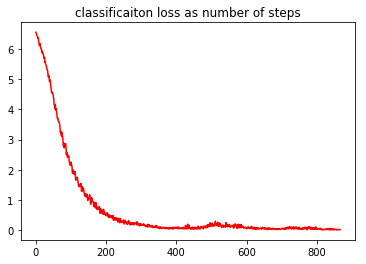

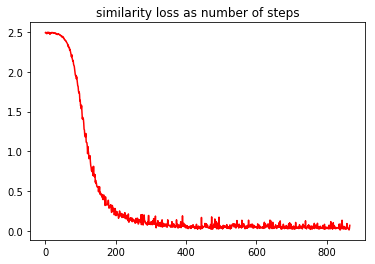

In [8]:
plot.title('classificaiton loss as number of steps')
plot.plot(loss_step, loss1_val, 'r')
plot.show()
plot.title('similarity loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

### Training and validation accuracy for classification and similarity check

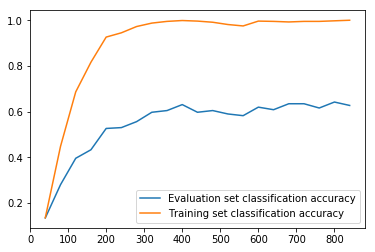

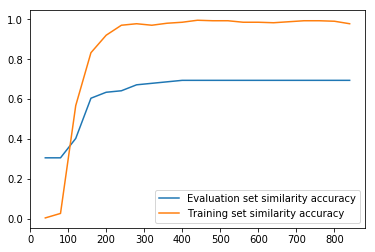

In [9]:
plot.plot(evaluation_step, acc_val, label='Evaluation set classification accuracy')
plot.plot(evaluation_step, acc_train, label='Training set classification accuracy')
plot.legend()
plot.show()
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.plot(evaluation_step, sim_train, label='Training set similarity accuracy')
plot.legend()
plot.show()

# Combined Loss, similarity threshold = 1

In [17]:
num_of_ids = len(subject_list)
loss1_val = []
loss2_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []
STEP_SIZE_LOSS = 10
STEP_SIZE_EVALUATE = 40


with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="COMBINED", similarity_threshold=1)
    for step, (batch_x, batch_y) in enumerate(train_ds):
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: loss1: %f loss2: %f" % (step, loss1, loss2)))
        if (step == 0):
            continue
        if (step % STEP_SIZE_EVALUATE == 0):
            # Evaluate on validation set
            accuracy, sim = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: classification accuracy: %f, similarity accuracy: %f" % (step, accuracy, sim)))
            acc_val.append(accuracy)
            sim_val.append(sim)
            evaluation_step.append(step)
            
            # Evaluate on training set
            accuracy, sim = model.test(batch_x, batch_y, similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: classification accuracy: %f, similarity accuracy: %f" % (step, accuracy, sim)))
            acc_train.append(accuracy)
            sim_train.append(sim)
    


[11.10|14:04:23] Step 0: loss1: 6.551428 loss2: 0.497745
[11.10|14:04:36] Step 10: loss1: 6.174478 loss2: 0.496505
[11.10|14:04:48] Step 20: loss1: 5.823500 loss2: 0.491380
[11.10|14:05:00] Step 30: loss1: 5.504508 loss2: 0.485937
[11.10|14:05:13] Step 40: loss1: 4.989424 loss2: 0.470450
[11.10|14:05:13] EVAL SET: Step 40: classification accuracy: 0.126866, similarity accuracy: 0.305970
[11.10|14:05:14] TRAIN SET: Step 40: classification accuracy: 0.121250, similarity accuracy: 0.000000
[11.10|14:05:26] Step 50: loss1: 4.515010 loss2: 0.435476
[11.10|14:05:38] Step 60: loss1: 3.972361 loss2: 0.377517
[11.10|14:05:50] Step 70: loss1: 3.329677 loss2: 0.288427
[11.10|14:06:03] Step 80: loss1: 3.049336 loss2: 0.192487
[11.10|14:06:03] EVAL SET: Step 80: classification accuracy: 0.246269, similarity accuracy: 0.425373
[11.10|14:06:04] TRAIN SET: Step 80: classification accuracy: 0.415000, similarity accuracy: 0.557500
[11.10|14:06:16] Step 90: loss1: 2.699328 loss2: 0.126037
[11.10|14:06:28

### Classification and Similarity Loss 

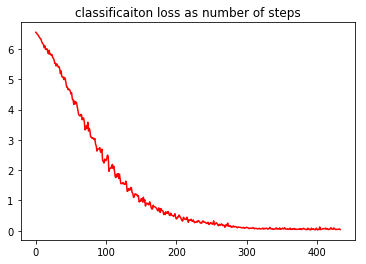

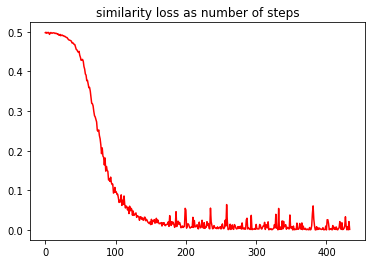

In [18]:
plot.title('classificaiton loss as number of steps')
plot.plot(loss_step, loss1_val, 'r')
plot.show()
plot.title('similarity loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

### Training and validation accuracy for classification and similarity check

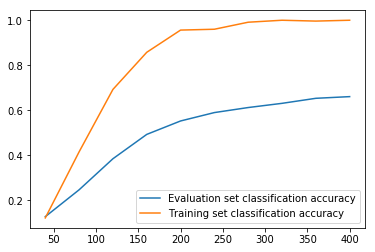

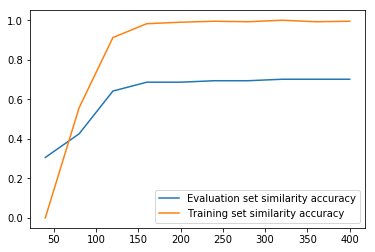

In [19]:
plot.plot(evaluation_step, acc_val, label='Evaluation set classification accuracy')
plot.plot(evaluation_step, acc_train, label='Training set classification accuracy')
plot.legend()
plot.show()
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.plot(evaluation_step, sim_train, label='Training set similarity accuracy')
plot.legend()
plot.show()

# Combined Loss, similarity threshold = 0.5

In [7]:
num_of_ids = len(subject_list)
loss1_val = []
loss2_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []
STEP_SIZE_LOSS = 10
STEP_SIZE_EVALUATE = 40


with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="COMBINED", similarity_threshold=0.5)
    for step, (batch_x, batch_y) in enumerate(train_ds):
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: loss1: %f loss2: %f" % (step, loss1, loss2)))
        if (step == 0):
            continue
        if (step % STEP_SIZE_EVALUATE == 0):
            # Evaluate on validation set
            accuracy, sim = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: classification accuracy: %f, similarity accuracy: %f" % (step, accuracy, sim)))
            acc_val.append(accuracy)
            sim_val.append(sim)
            evaluation_step.append(step)
            
            # Evaluate on training set
            accuracy, sim = model.test(batch_x, batch_y, similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: classification accuracy: %f, similarity accuracy: %f" % (step, accuracy, sim)))
            acc_train.append(accuracy)
            sim_train.append(sim)
    


[11.10|14:21:39] Step 0: loss1: 6.556445 loss2: 0.248664
[11.10|14:21:51] Step 10: loss1: 6.115303 loss2: 0.247457
[11.10|14:22:03] Step 20: loss1: 5.729361 loss2: 0.244332
[11.10|14:22:16] Step 30: loss1: 5.305739 loss2: 0.234896
[11.10|14:22:28] Step 40: loss1: 4.534792 loss2: 0.217408
[11.10|14:22:29] EVAL SET: Step 40: classification accuracy: 0.164179, similarity accuracy: 0.305970
[11.10|14:22:29] TRAIN SET: Step 40: classification accuracy: 0.212500, similarity accuracy: 0.017500
[11.10|14:22:41] Step 50: loss1: 4.160188 loss2: 0.181279
[11.10|14:22:54] Step 60: loss1: 3.444612 loss2: 0.132507
[11.10|14:23:06] Step 70: loss1: 2.853049 loss2: 0.085770
[11.10|14:23:18] Step 80: loss1: 2.490742 loss2: 0.043759
[11.10|14:23:19] EVAL SET: Step 80: classification accuracy: 0.365672, similarity accuracy: 0.611940
[11.10|14:23:20] TRAIN SET: Step 80: classification accuracy: 0.536250, similarity accuracy: 0.852500
[11.10|14:23:31] Step 90: loss1: 2.042086 loss2: 0.021507
[11.10|14:23:44

### Classification and Similarity Loss 

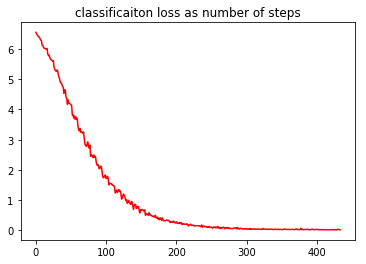

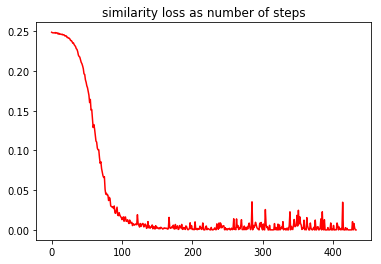

In [8]:
plot.title('classificaiton loss as number of steps')
plot.plot(loss_step, loss1_val, 'r')
plot.show()
plot.title('similarity loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

### Training and validation accuracy for classification and similarity check

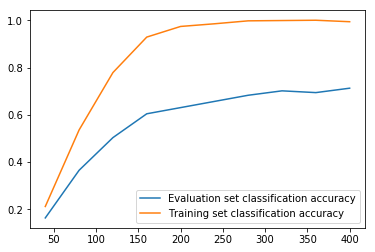

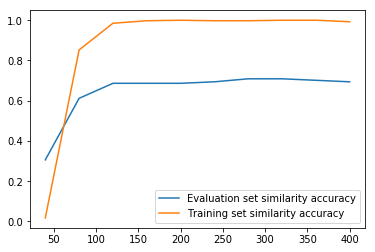

In [9]:
plot.plot(evaluation_step, acc_val, label='Evaluation set classification accuracy')
plot.plot(evaluation_step, acc_train, label='Training set classification accuracy')
plot.legend()
plot.show()
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.plot(evaluation_step, sim_train, label='Training set similarity accuracy')
plot.legend()
plot.show()